In [1]:
import os
import numpy as np # linear algebra
import pandas as pd 
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import warnings
warnings.filterwarnings("ignore")


In [2]:
# Basic libraries
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET

# For model and training
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense


In [3]:
# Path to images and annotations
IMG_PATH = "images"
ANN_PATH = "annotations"


In [4]:
import os
import cv2
import xml.etree.ElementTree as ET

data = []
labels = []

IMG_PATH = "images"
ANN_PATH = "annotations"

for file in os.listdir(ANN_PATH):
    tree = ET.parse(os.path.join(ANN_PATH, file))
    root = tree.getroot()

    image_file = root.find('filename').text
    label = root.find('object').find('name').text

    # Get bounding box coordinates
    bbox = root.find('object').find('bndbox')
    xmin = int(bbox.find('xmin').text)
    ymin = int(bbox.find('ymin').text)
    xmax = int(bbox.find('xmax').text)
    ymax = int(bbox.find('ymax').text)

    # Load image
    img_path = os.path.join(IMG_PATH, image_file)
    img = cv2.imread(img_path)

    if img is None:
        print(f"Warning: Could not read image {img_path}")
        continue

    # Crop to face bounding box
    face = img[ymin:ymax, xmin:xmax]

    # Resize and preprocess
    face = cv2.resize(face, (100, 100))
    face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)

    data.append(face)
    labels.append(label)


In [5]:
# Convert string labels to numbers
label_map = {"with_mask": 0, "without_mask": 1, "mask_weared_incorrect": 2}
labels = [label_map[lbl] for lbl in labels]

# Convert to NumPy arrays
X = np.array(data) / 255.0  # Normalize pixel values to [0,1]
y = to_categorical(labels, num_classes=3)  # One-hot encode labels


In [7]:
# Split into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [17]:
# Define a simple Convolutional Neural Network
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(100, 100, 3)),  # First conv layer
    MaxPooling2D(),  # Downsample

    Conv2D(64, (3,3), activation='relu'),  # Second conv layer
    MaxPooling2D(),  # Downsample again

    Flatten(),  # Flatten the feature map
    Dense(64, activation='relu'),  # Fully connected layer
    Dense(3, activation='softmax')  # Output layer (3 classes)
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [18]:
# Train for 5 epochs (adjustable)
model.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test))


Epoch 1/5
22/22 [==============================] - 7s 254ms/step - loss: 0.8673 - accuracy: 0.8021 - val_loss: 0.3945 - val_accuracy: 0.8538
Epoch 2/5
22/22 [==============================] - 5s 233ms/step - loss: 0.4572 - accuracy: 0.8255 - val_loss: 0.2591 - val_accuracy: 0.9298
Epoch 3/5
22/22 [==============================] - 5s 221ms/step - loss: 0.2886 - accuracy: 0.8959 - val_loss: 0.1882 - val_accuracy: 0.9649
Epoch 4/5
22/22 [==============================] - 5s 237ms/step - loss: 0.2327 - accuracy: 0.9282 - val_loss: 0.1526 - val_accuracy: 0.9649
Epoch 5/5
22/22 [==============================] - 5s 233ms/step - loss: 0.1897 - accuracy: 0.9311 - val_loss: 0.1419 - val_accuracy: 0.9532


In [19]:
# Evaluate on test data
loss, acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {acc:.2f}")


6/6 [==============================] - 0s 45ms/step - loss: 0.1419 - accuracy: 0.9532
Test Accuracy: 0.95


1/1 [==============================] - 0s 325ms/step
[[9.9898535e-01 6.2864518e-07 1.0140172e-03]
 [7.5393283e-01 1.9879051e-01 4.7276679e-02]
 [9.4342983e-01 3.6240857e-02 2.0329304e-02]
 [9.9994278e-01 4.8254054e-07 5.6787056e-05]
 [9.9964726e-01 6.6814711e-05 2.8587610e-04]
 [9.9950480e-01 2.3100360e-05 4.7211774e-04]
 [6.5190047e-01 3.2234329e-01 2.5756227e-02]
 [9.9733609e-01 2.1424250e-05 2.6425463e-03]
 [8.6171901e-01 5.6533370e-02 8.1747562e-02]
 [4.2569336e-01 3.6640871e-01 2.0789784e-01]
 [9.0228909e-01 5.6132045e-02 4.1578904e-02]
 [9.7116852e-01 8.7346295e-03 2.0096814e-02]
 [9.9870968e-01 1.7473637e-06 1.2885913e-03]
 [9.9782830e-01 1.0400460e-04 2.0676665e-03]
 [1.9225007e-01 7.9420471e-01 1.3545154e-02]
 [9.1504425e-01 9.3670012e-03 7.5588711e-02]
 [9.9961674e-01 3.5672678e-04 2.6490614e-05]
 [9.6373725e-01 1.6430529e-02 1.9832235e-02]
 [9.9146700e-01 2.3996888e-03 6.1333915e-03]
 [9.9972123e-01 2.6689272e-04 1.1951427e-05]]


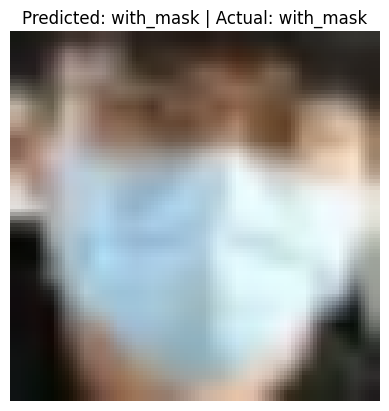

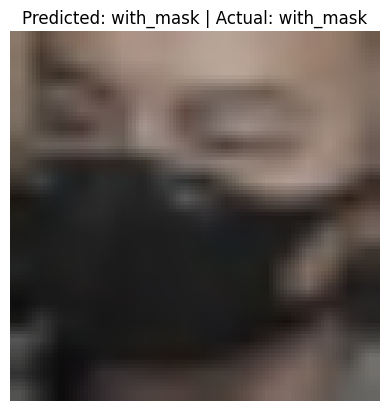

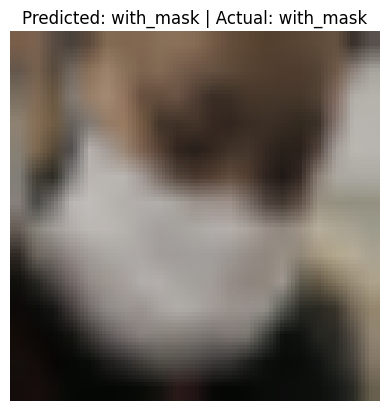

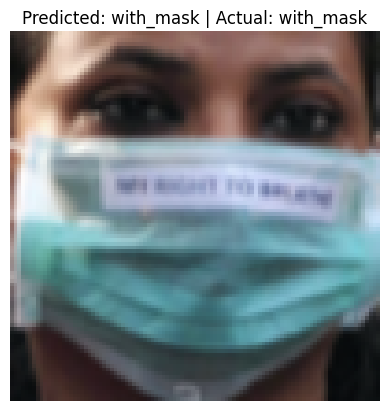

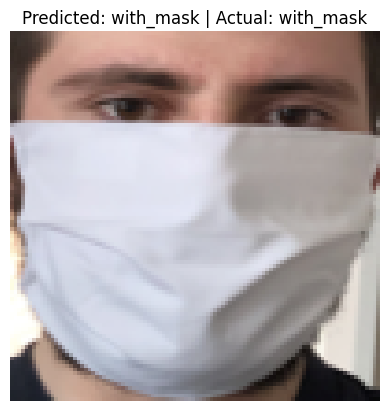

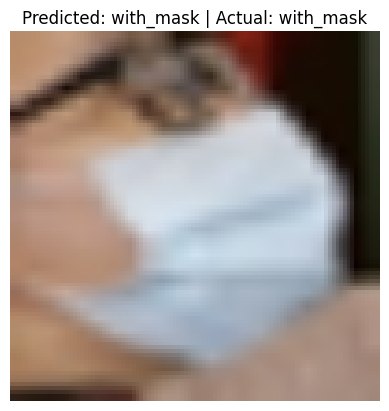

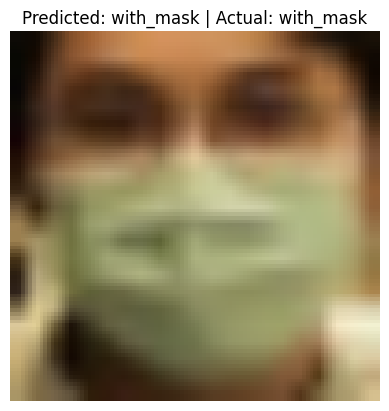

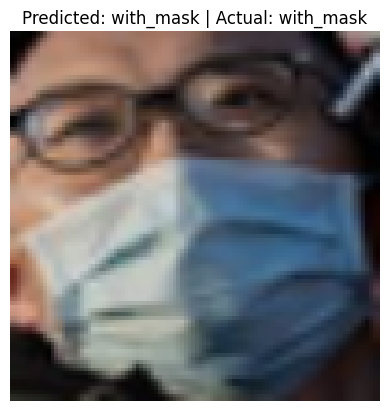

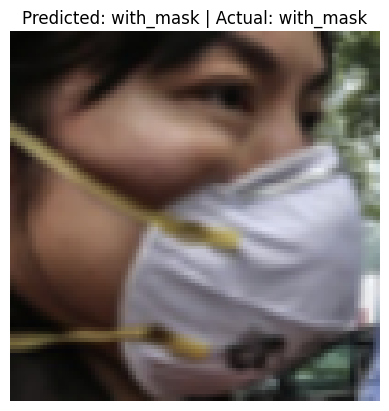

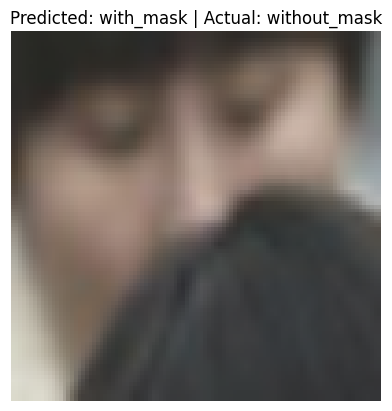

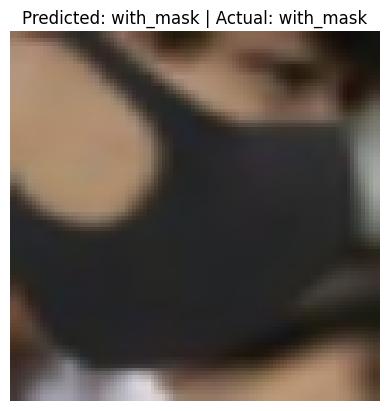

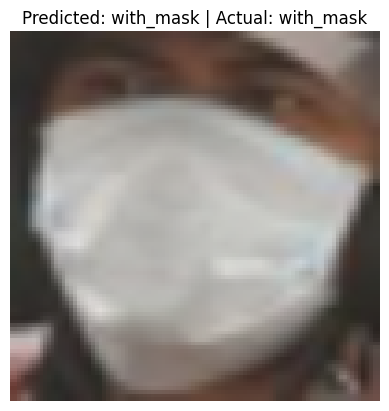

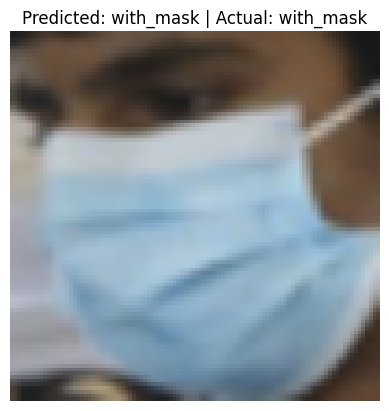

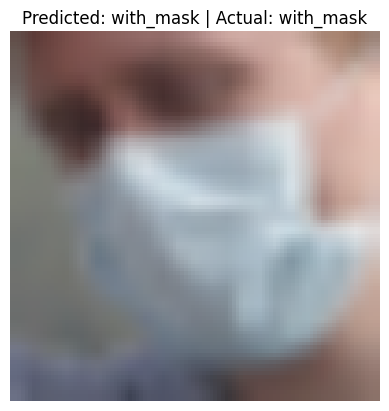

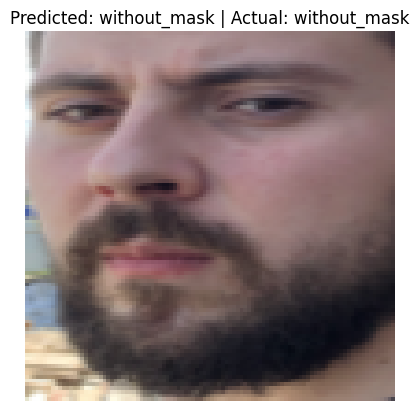

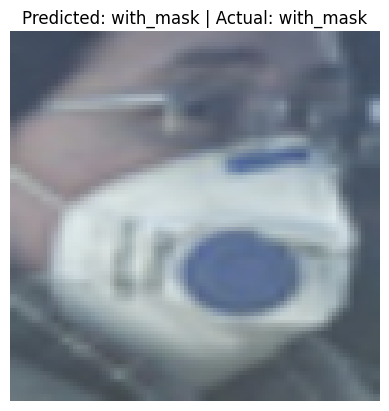

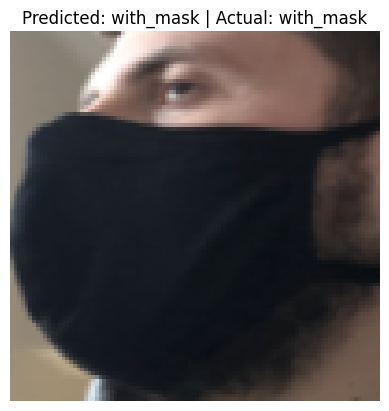

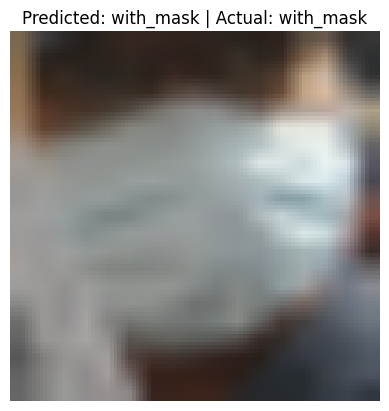

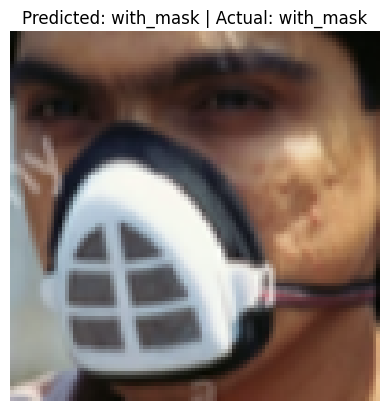

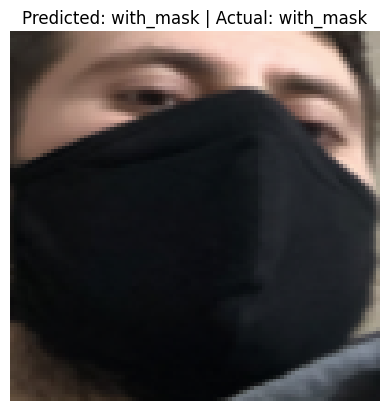

In [8]:
# Predict on first 5 test images
import cv2
import numpy as np
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

# Load the trained model
model = load_model("model/Face_model_new2.h5")
preds = model.predict(X_test[:20])
print(preds)
classes = ["with_mask", "without_mask", "mask_weared_incorrect"]

# Display images with predictions
for i in range(20):
    plt.imshow(X_test[i])
    pred_label = classes[np.argmax(preds[i])]
    true_label = classes[np.argmax(y_test[i])]
    plt.title(f"Predicted: {pred_label} | Actual: {true_label}")
    plt.axis('off')
    plt.show()


1/1 [==============================] - 0s 33ms/step


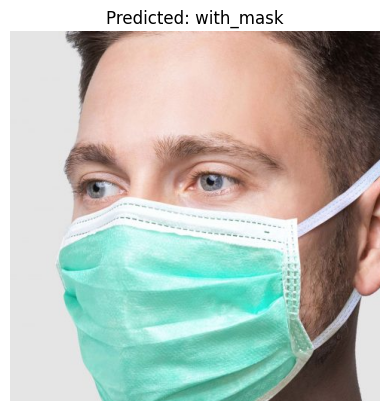

Prediction (raw probabilities): [[8.7858671e-01 6.1719802e-05 1.2135161e-01]]
Predicted class: with_mask


In [9]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

# Load the trained model

# Class labels
classes = ["with_mask", "without_mask", "mask_weared_incorrect"]

# Expected input size for the model
input_size = (100, 100)

# Load Haar Cascade for face detection (optional, but improves accuracy)
faceCascade = cv2.CascadeClassifier("model/haarcascade_frontalface_default.xml")

# Read the image
img = cv2.imread("2.jpg")
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Detect face (optional but recommended)
faces = faceCascade.detectMultiScale(img_gray, 1.3, 5)

if len(faces) == 0:
    print("No face detected.")
else:
    x, y, w, h = faces[0]  # Use first face detected
    face_img = img[y:y+h, x:x+w]
    face_rgb = cv2.cvtColor(face_img, cv2.COLOR_BGR2RGB)
    face_resized = cv2.resize(face_rgb, input_size)
    face_normalized = face_resized / 255.0
    face_input = np.expand_dims(face_normalized, axis=0)

    # Predict
    preds = model.predict(face_input)
    pred_label = classes[np.argmax(preds)]

    # Show result
    plt.imshow(face_rgb)
    plt.title(f"Predicted: {pred_label}")
    plt.axis('off')
    plt.show()

    print("Prediction (raw probabilities):", preds)
    print("Predicted class:", pred_label)


In [21]:
model.save("Face_model_new2.h5")

